In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from adapt.feature_based import FA

from skopt import BayesSearchCV
from skopt.space import Categorical, Integer
from sklearn.metrics import classification_report

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


np.int = int


In [2]:
Xs_train    = pd.read_pickle('X_s_train.pkl')
Xs_test     = pd.read_pickle('X_s_test.pkl')[Xs_train.columns]
Xt_train    = pd.read_pickle('X_t_train.pkl')[Xs_train.columns]
Xt_test     = pd.read_pickle('X_t_test.pkl')[Xs_train.columns]
ys_train    = pd.read_pickle('y_s_train.pkl')
ys_test     = pd.read_pickle('y_s_test.pkl')
yt_train    = pd.read_pickle('y_t_train.pkl')
yt_test     = pd.read_pickle('y_t_test.pkl')

In [3]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # Define class labels (change to your own class labels)
    class_labels = ["Class 1", "Class 2", "Class 3"]
    
    # Create a heatmap of the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust the font scale for better readability
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False, square=True,
                xticklabels=class_labels, yticklabels=class_labels)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [4]:
class_weights = compute_class_weight('balanced', classes=np.unique(ys_train), y=ys_train)

In [43]:
from sklearn.model_selection import GridSearchCV

forest_clf = RandomForestClassifier(class_weight={idx + 1: weight for idx, weight in enumerate(class_weights)})

#search_space = {
#        "bootstrap": Categorical([True, False]), # values for boostrap can be either True or False
#        "max_depth": Integer(1, 10), 
#        "max_features": Categorical(['sqrt','log2']), 
#        "min_samples_leaf": Integer(5, 15),
#        "min_samples_split": Integer(7, 10),
#        "n_estimators": Integer(50, 1000)
#    }

search_space = {
        "bootstrap": [False], 
        "max_depth": list(range(5, 9)), 
        "max_features": ['sqrt','log2'], 
        "min_samples_leaf": list(range(8, 13)),
        "min_samples_split": list(range(5, 10)),
        "n_estimators": list(range(140, 734))
    }

#forest_bayes_search = BayesSearchCV(forest_clf, search_space, n_iter=50, scoring="f1_weighted", cv=5)

grid_search = GridSearchCV(estimator=forest_clf, param_grid=search_space, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(Xs_train, ys_train)

#forest_bayes_search.fit(Xs_train, ys_train)

#best_params = forest_bayes_search.best_params_
#best_model = forest_bayes_search.best_estimator_
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [44]:
best_params

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 5,
 'n_estimators': 143}

--------------- TRAIN -----------------------


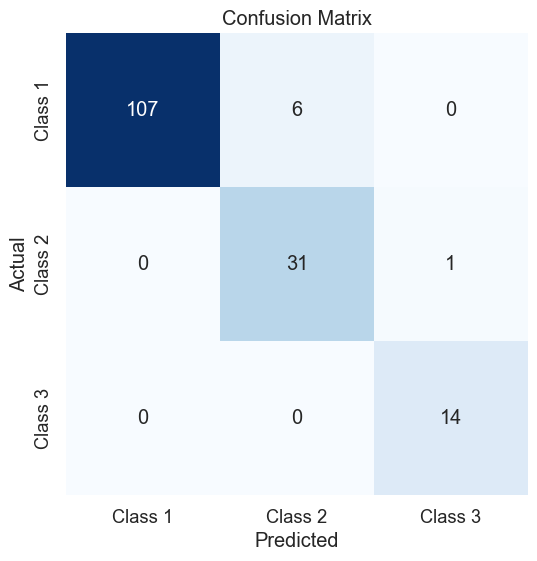

              precision    recall  f1-score   support

           1       1.00      0.95      0.97       113
           2       0.84      0.97      0.90        32
           3       0.93      1.00      0.97        14

    accuracy                           0.96       159
   macro avg       0.92      0.97      0.95       159
weighted avg       0.96      0.96      0.96       159

--------------- TEST -----------------------


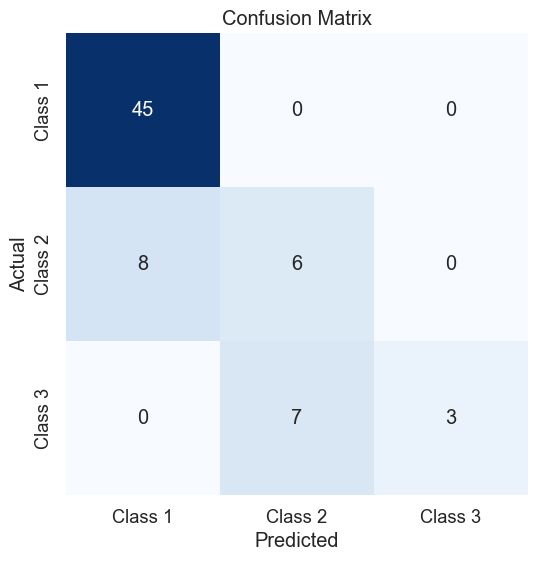

              precision    recall  f1-score   support

           1       0.85      1.00      0.92        45
           2       0.46      0.43      0.44        14
           3       1.00      0.30      0.46        10

    accuracy                           0.78        69
   macro avg       0.77      0.58      0.61        69
weighted avg       0.79      0.78      0.76        69



In [45]:
print('--------------- TRAIN -----------------------')
conf_matrix(ys_train, best_model.predict(Xs_train))
print(classification_report(ys_train, best_model.predict(Xs_train)))
print('--------------- TEST -----------------------')
conf_matrix(ys_test, best_model.predict(Xs_test))
print(classification_report(ys_test, best_model.predict(Xs_test)))

In [46]:
def subsample_df(df, y, percentage):
    size_by_id = Xt_train.index.get_level_values(0).value_counts()
    number_rows_to_select = (size_by_id * percentage).astype(int)
    
    df_to_create = pd.DataFrame(columns=df.columns)
    selected_indices = []

    for id, id_group in df.groupby(level=0):
        selected_rows = id_group.sample(n=number_rows_to_select[id], random_state=42)
        df_to_create = pd.concat([df_to_create, selected_rows])
        selected_indices.extend(selected_rows.index)

    y_to_create = y.loc[selected_indices]
    
    return df_to_create, y_to_create


In [51]:
#percent_to_select = 0.5  
#group_sizes = Xt_train.index.get_level_values(0)
#group_sizes = Xt_train.index.get_level_values(0).value_counts()
#rows_to_select = (group_sizes * percent_to_select).astype(int)
#selected_df = pd.DataFrame(columns=Xt_train.columns)
#selected_indices = []
# Randomly select rows for each ID
#for id_value, group in Xt_train.groupby(level=0):
#    selected_rows = group.sample(n=rows_to_select[id_value], random_state=42)
#    selected_df = pd.concat([selected_df, selected_rows])
#    selected_indices.extend(selected_rows.index)

# Reset the index of the selected DataFrame
#selected_df.reset_index(inplace=True)
#y_values = yt_train.loc[selected_indices]

selected_df, y_values = subsample_df(Xt_train, yt_train, 1)

model = FA(best_model, Xt=selected_df, yt=y_values, random_state=9)

model.fit(Xs_train, ys_train)
#model.fit_transform(Xs_train, Xt_train, ys_train, yt_train)


model.score(Xt_train, yt_train)
model.score(Xt_test, yt_test)

Fit transform...
Previous shape: (159, 43)
New shape: (180, 129)
Fit Estimator...


0.5

In [52]:
print(classification_report(yt_train, model.predict(Xt_train)))

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           2       0.00      0.00      0.00         3
           3       0.88      1.00      0.93        14

    accuracy                           0.86        21
   macro avg       0.56      0.67      0.61        21
weighted avg       0.74      0.86      0.79        21



c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


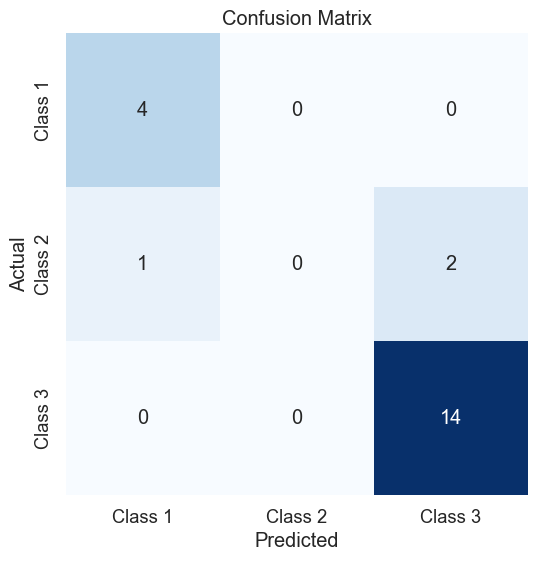

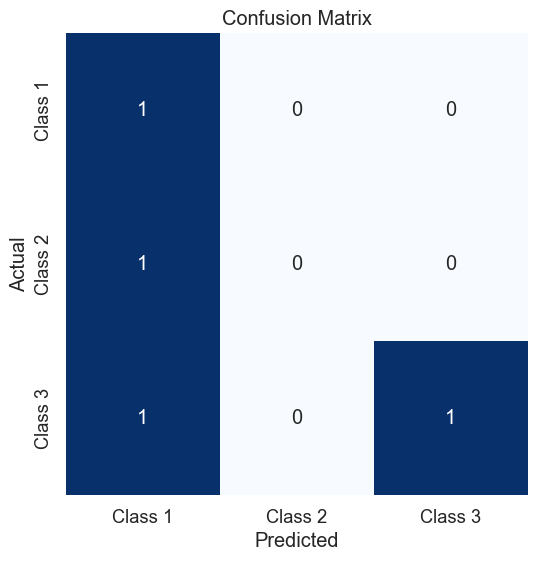

In [53]:
conf_matrix(yt_train, model.predict(Xt_train))
conf_matrix(yt_test, model.predict(Xt_test))


In [16]:
Xs_train

x__length  x__count_below_mean  \
1  2023-01-01 10:13:19.585   247040.0             123314.0   
   2023-01-01 10:28:19.585   362240.0             180943.0   
   2023-01-01 10:43:19.585   477440.0             238456.0   
   2023-01-01 10:58:19.585   592640.0             296155.0   
   2023-01-01 11:13:19.585   707840.0             353289.0   
...                               ...                  ...   
9  2023-01-01 10:05:24.710   477440.0             237009.0   
   2023-01-01 10:20:24.710   592640.0             293929.0   
   2023-01-01 10:35:24.710   707840.0             351365.0   
   2023-01-01 10:50:24.710   823040.0             407784.0   
10 2023-01-01 09:15:49.960   247040.0             122196.0   

                            x__ratio_value_number_to_time_series_length  \
1  2023-01-01 10:13:19.585                                     0.014281   
   2023-01-01 10:28:19.585                                     0.009764   
   2023-01-01 10:43:19.585                                     0.007417   
   2023-01-01 10:58:19.585                                     0.006000   
   2023-01-01 11:13:19.585                                     0.005029   
...                                                                 ...   
9  2023-01-01 10:05:24.710                                     0.004773   
   2023-01-01 10:20:24.710                                     0.003849   
   2023-01-01 10:35:24.710                                     0.003232   
   2023-01-01 10:50:24.710                                     0.002786   
10 2023-01-01 09:15:49.960                                     0.010836   

                            x__cid_ce__normalize_True  \
1  2023-01-01 10:13:19.585                 704.687471   
   2023-01-01 10:28:19.585                 852.221645   
   2023-01-01 10:43:19.585                 977.823269   
   2023-01-01 10:58:19.585                1089.104567   
   2023-01-01 11:13:19.585                1190.469747   
...                                               ...   
9  2023-01-01 10:05:24.710                 975.352036   
   2023-01-01 10:20:24.710                1086.180105   
   2023-01-01 10:35:24.710                1187.544063   
   2023-01-01 10:50:24.710                1280.063537   
10 2023-01-01 09:15:49.960                 702.963898   

                            x__number_cwt_peaks__n_5  x__number_peaks__n_3  \
1  2023-01-01 10:13:19.585                   19610.0               35235.0   
   2023-01-01 10:28:19.585                   28770.0               51701.0   
   2023-01-01 10:43:19.585                   38062.0               68122.0   
   2023-01-01 10:58:19.585                   46744.0               84324.0   
   2023-01-01 11:13:19.585                   55775.0              101107.0   
...                                              ...                   ...   
9  2023-01-01 10:05:24.710                   38004.0               67985.0   
   2023-01-01 10:20:24.710                   47209.0               84529.0   
   2023-01-01 10:35:24.710                   56268.0              100840.0   
   2023-01-01 10:50:24.710                   65056.0              117574.0   
10 2023-01-01 09:15:49.960                   19350.0               35184.0   

                            x__number_peaks__n_10  x__number_peaks__n_50  \
1  2023-01-01 10:13:19.585                11746.0                 2360.0   
   2023-01-01 10:28:19.585                17078.0                 3505.0   
   2023-01-01 10:43:19.585                22624.0                 4627.0   
   2023-01-01 10:58:19.585                28017.0                 5754.0   
   2023-01-01 11:13:19.585                33414.0                 6862.0   
...                                           ...                    ...   
9  2023-01-01 10:05:24.710                22569.0                 4786.0   
   2023-01-01 10:20:24.710                28053.0                 5955.0   
   2023-01-01 10:35:24.710                33511.0                 7084.0   


In [41]:
import joblib

In [50]:
joblib.dump(model, 'baseline_model_test.pkl')

['baseline_model_depth.pkl']

In [65]:
print(classification_report(yt_test, model_temp.predict(Xt_test)))

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       0.00      0.00      0.00         1
           3       1.00      0.50      0.67         2

    accuracy                           0.50         4
   macro avg       0.44      0.50      0.39         4
weighted avg       0.58      0.50      0.46         4



c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\KombiWZM\anaconda3\envs\BAR_TS\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
